# Classification. Linear models and KNN

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [4]:
PATH = "./data/"

In [1088]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [6]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [152]:
# Helper function
def plot_barchart(index, datas, labels, title, ylabel):
    p1 = plt.bar(index, datas[0], 0.35)
    p2 = plt.bar(index, datas[1], 0.35,
                 bottom=datas[0])

    plt.ylabel(ylabel)
    plt.title(title)
    plt.ylim(0, 1.1)
    if labels:
        plt.legend((p1[0], p2[0]), labels)

    plt.show()    

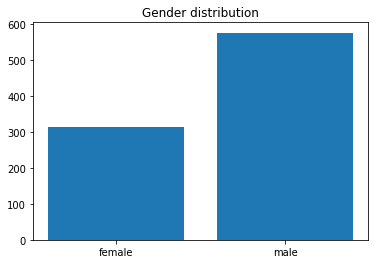

In [76]:
# Genders
genders = data.groupby(['Sex'])['Sex'].count()

plt.bar(genders.index, genders)
plt.title('Gender distribution')
plt.show()

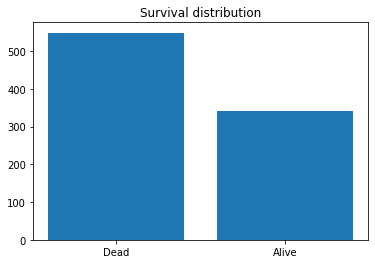

In [77]:
# Genders
survival = data.groupby(['Survived'])['Survived'].count()

plt.bar(['Dead', 'Alive'], survival)
plt.title('Survival distribution')
plt.show()

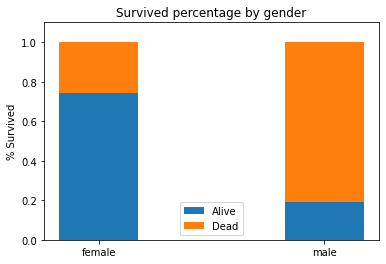

In [147]:
aliveMeans = data[data['Survived'] == 1].groupby(['Sex'])['Sex'].count() / data.groupby(['Sex'])['Survived'].count()
deadMeans = data[data['Survived'] == 0].groupby(['Sex'])['Sex'].count() / data.groupby(['Sex'])['Survived'].count()

plot_barchart(aliveMeans.index, [aliveMeans, deadMeans],('Alive', 'Dead'), 'Survived percentage by gender', '% Survived' )

**Conclusion:** You'd better to be a female to survive on Titanic, probability to stay alive almost 3 time higher than for male.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

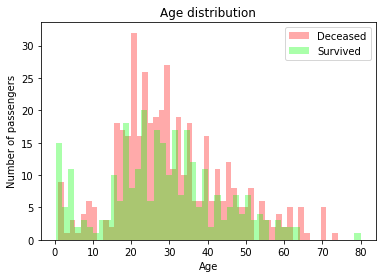

In [1035]:
plt.hist(data[data['Survived'] ==0]['Age'].dropna(), bins=50, label='Deceased', color='#ff000055' )
plt.hist(data[data['Survived'] ==1]['Age'].dropna(), bins=50, label='Survived', color='#00ff0055')
plt.title('Age distribution')
plt.ylabel('Number of passengers')
plt.xlabel('Age')
plt.legend()
plt.show()

In [1025]:
# Average age
data[['Age', 'Survived']].dropna().groupby(['Survived']).mean()

,Age
Survived,
0,30.626179
1,28.343690


In [99]:
# Median age
data[['Age', 'Survived']].dropna().groupby(['Survived']).median()

,Age
Survived,
0,28.0
1,28.0


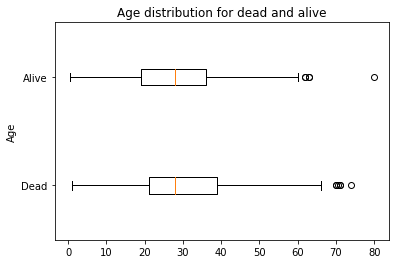

In [134]:
# Age distibution for dead/alive
age_survival = data[['Age', 'Survived']].dropna()

plt.boxplot([age_survival[(age_survival['Survived'] == 0)]['Age'], 
             age_survival[(age_survival['Survived'] == 1)]['Age']], labels=['Dead', 'Alive'], vert=False)

plt.title('Age distribution for dead and alive')
plt.ylabel('Age')
plt.show()

**Thoughts:** Age distibution for dead and alive a little bit different: very old people is likely to decease. Average and median ages are almost the same.
Observation can be easily explained: youngers are faster and theirs health is stronger.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

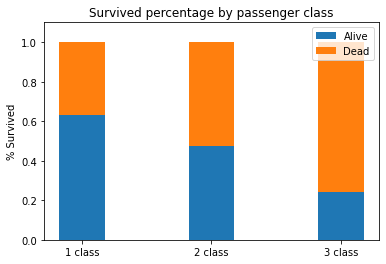

In [164]:
# Passenger class
pclass_enum = sorted([f'{x} class' for x in data['Pclass'].dropna().unique()])

plot_barchart(pclass_enum, [data[data['Survived'] == 1].groupby(['Pclass'])['Pclass'].count() / data.groupby(['Pclass'])['Survived'].count(),
                                                   data[data['Survived'] == 0].groupby(['Pclass'])['Pclass'].count() / data.groupby(['Pclass'])['Survived'].count()],
                                        ('Alive', 'Dead'), 
                                      'Survived percentage by passenger class', '% Survived' )

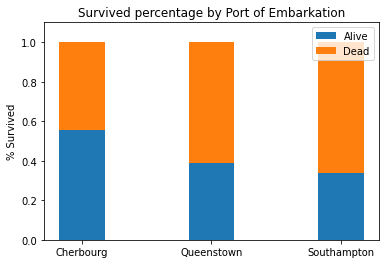

In [166]:
# Embarked
embarked_enum = {'C': 'Cherbourg', 'Q': 'Queenstown', 'S':'Southampton'}
embarked_enum = sorted([embarked_enum[x] for x in data['Embarked'].dropna().unique()])

plot_barchart(embarked_enum, [data[data['Survived'] == 1].groupby(['Embarked'])['Embarked'].count() / data.groupby(['Embarked'])['Survived'].count(),
                                                   data[data['Survived'] == 0].groupby(['Embarked'])['Embarked'].count() / data.groupby(['Embarked'])['Survived'].count()],
                      ('Alive', 'Dead'),
                      'Survived percentage by Port of Embarkation', 
                      '% Survived' )


**Thoughts:** First-class passengers are more likely to survive. Port of embarkation has light influence on survival probability. Cherbourg is a France town, so survival might be related to nationality.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [30]:
data.isnull().mean() * 100

Survived     0.000000
Pclass       0.000000
Name         0.000000
Sex          0.000000
Age         19.865320
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.000000
Cabin       77.104377
Embarked     0.224467
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

**Thoughts:** 
- For `Embarked` add new value 'NA'
    (`+` - separate calculations for 'unknown' port, `-` - survival probability for real ports might be incorrect)
- For `Cabin` drop feature, because too many missing values 
    (`+` - lower noise in model, `-` - probable missing influence of passenger location)
- For `Age` suggest mean for passengers of the salutation/title.
    (`+` - age is taken into account, `-` - probable incorrect age for passenges)

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [330]:
y = data['Survived']

In [1291]:
# Data preparation
# - Divide dataset in 3 parts for children, adult and aged people
# - Use different models for these parts
# - `Age` and `Fare` are meaningful only for adults
# - `Family` is useful for all ages
# - `Ticket` might identify people traveling together

np.random.seed(52)

# Read all available data
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
test_data_preprocess = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')
# Combine datasets to create correct ranges for Age and Fare
whole_data = data.append(test_data_preprocess)

# Number of persons in family: parents + siblilngs
whole_data['Family'] = whole_data['Parch'] + whole_data['SibSp']

# Extract family name for every person
whole_data['FamilyName'] = whole_data['Name'].str.split(',', expand=True)[0]

# Detect real 'families': several persons with the same surname
families = whole_data[(whole_data['Parch'] + whole_data['SibSp'] > 0)]['FamilyName'].unique()

# Do the same for train dataset
data['FamilyName'] = data['Name'].str.split(',', expand=True)[0]

# Detect families who most likely survived or not. 
# Assumption: people in the same family have similar chances to survive, especially children
survived_families = data[(data['FamilyName'].isin(families)) & (data['Survived'] == 1)]['FamilyName'].unique()
deceased_families = data[(data['FamilyName'].isin(families)) & (data['Survived'] == 0)]['FamilyName'].unique()

# Detect missing ages base on person title
title_remap = {' Mr': 'Mr', ' Mrs': 'Mrs', ' Miss': 'Miss', ' Master': 'Master', ' Don': 'Mr', ' Rev': 'Rev', ' Dr': 'Mr', ' Mme': 'Mrs',
   ' Ms': 'Miss', ' Major': 'Mr', ' Lady': 'Mrs', ' Sir': 'Mr', ' Mlle': 'Miss', ' Col': 'Mr', ' Capt': 'Mr',
   ' the Countess': 'Mrs', ' Jonkheer': 'Mr', ' Dona': 'Mrs'}

# Extract title and remap
whole_data['Title'] = whole_data['Name'].str.split('[,.]', expand=True)[1].replace(title_remap)
# Fill missing ages with median in the same title
whole_data['PreparedAge'] = whole_data['Age'].fillna(whole_data.groupby(['Title'])['Age'].transform('median'))

# Ages breakpoints.
# Assumption: children, adults and aged people should have different models for prediction
child_age = 17
aged_age = 65

# Fill AgeRange only for adults. Age is suggested non-meaningful for children and aged people
whole_data.loc[(whole_data['PreparedAge'] >= child_age) 
               | (whole_data['PreparedAge'] < aged_age), 'AgeRange'] = pd.qcut(
            whole_data[(whole_data['PreparedAge'] >= child_age) 
                       | (whole_data['PreparedAge'] < aged_age)]['PreparedAge'], 4)

# Fill missing fare based on median of the same person class
whole_data['PreparedFare'] = whole_data['Fare'].fillna(whole_data.groupby(['Pclass'])['Fare'].transform('mean'))

# Fill FareRange only for adults. Fare is suggested non-meaningful for children and aged people
whole_data.loc[(whole_data['PreparedAge'] >= child_age) 
               | (whole_data['PreparedAge'] < aged_age), 'FareRange'] = pd.qcut(
            whole_data[(whole_data['PreparedAge'] >= child_age) 
                       | (whole_data['PreparedAge'] < aged_age)]['PreparedFare'], 5)

# Assumption: people having the same ticket are travelling together (family-like). Count person-per-ticket feature
whole_data['TicketCount'] = whole_data.groupby('Ticket')['Ticket'].transform('count')

# Calculate probabily to survive based on size of group with one ticket. Looks correlated with survival
whole_data['SurvivalPerTicketCount'] = whole_data.groupby('TicketCount')['Survived'].transform('mean')

# Extract train dataset from whole_data and split it for child, adult and aged
y = whole_data[:891]
y_child = y[y['PreparedAge'] < child_age]['Survived']
y_adult = y[(y['PreparedAge'] >= child_age) & (y['PreparedAge'] < aged_age)]['Survived']
y_aged = y[y['PreparedAge'] >= aged_age]['Survived']

# Function to transform train and test data
def transform_data(df, ageRange='adult'):
    # Add pre-calculated columns from whole_data
    df = df.join(whole_data[['FareRange', 'AgeRange', 'Family', 'SurvivalPerTicketCount', 'PreparedAge']])

    # Extract family name. Again.
    df['FamilyName'] = df['Name'].str.split(',', expand=True)[0]
    
    # Define "family survival": feature shows is anybody from family survived or everybody deceased
    # Useful for child and aged people
    df['FamilySurvival'] = 0.5
    df.loc[df['FamilyName'].isin(survived_families) & (df['FamilySurvival'] == 0.5), 'FamilySurvival'] = 1
    df.loc[df['FamilyName'].isin(deceased_families) & (df['FamilySurvival'] == 0.5), 'FamilySurvival'] = 0

    # Some features encoding
    df['SexCode'] = LabelEncoder().fit_transform(df['Sex'])
    df['FareRangeCode'] = LabelEncoder().fit_transform(df['FareRange'])
    df['AgeRangeCode'] = LabelEncoder().fit_transform(df['AgeRange'])

    # Looks useful fo children
    df['EmbarkedCode'] = LabelEncoder().fit_transform(df['Embarked'])
    
    # Special feature to identify alone children
    df['AloneCode'] = LabelEncoder().fit_transform(df['Family'] == 0)

    # Return child, adult or aged based on funcition parameters
    if ageRange == 'children':
        df = df[df['PreparedAge'] < child_age][[
        'Pclass', 'FamilySurvival', 'Family', 'EmbarkedCode', 'AloneCode']]
    elif ageRange == 'aged':
        df = df[df['PreparedAge'] >= aged_age][[
        'Pclass', 'FamilySurvival', 'Family']]
    else:
        df = df[(df['PreparedAge'] >= child_age) & (df['PreparedAge'] < aged_age)][['Family',
        'AgeRangeCode', 'SexCode', 'Pclass', 'FareRangeCode', 'SurvivalPerTicketCount']]

    std_scaler = StandardScaler()
    # Do final standartization and return scaled data and result dataframe for testing purposes
    return std_scaler.fit_transform(df), df

In [1292]:
# Score here means nothing for kaggle, because it's fight for approximately 15 predictions from 1309 items
# But task requires to do this
X_train, _ = transform_data(data.copy(), 'adult')

log_model = LogisticRegression(solver='liblinear', penalty='l1')
knn_model = KNeighborsClassifier()

log_model.fit(X=X_train, y=y_adult)
knn_model.fit(X=X_train, y=y_adult)

print( f'LogisticRegression model accuracy: {accuracy_score(y_adult, log_model.predict(X_train))}')
print( f'KNeighborsClassifier model accuracy: {accuracy_score(y_adult, knn_model.predict(X_train))}')

print( f'LogisticRegression model cross validate score (mean): {cross_validate(log_model, X_train, y_adult, cv=5)["test_score"].mean()}')
print( f'KNeighborsClassifier model cross validate score (mean): {cross_validate(knn_model, X_train, y_adult, cv=5)["test_score"].mean()}')


LogisticRegression model accuracy: 0.8234536082474226
KNeighborsClassifier model accuracy: 0.8479381443298969
LogisticRegression model cross validate score (mean): 0.8093134822167081
KNeighborsClassifier model cross validate score (mean): 0.8093796526054591


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [1275]:
# Code to brute-force model hyper-params. Results are just a suggestion..
# Major outcome from all experiments: best values are around weights='uniform', algorithm='auto', k=[20;28]
X_train, _ = transform_data(data.copy(), 'children')
res_max = 0
for neighb in np.arange(2, 36):
    for algo in['auto', 'ball_tree', 'kd_tree', 'brute']:
        for w in ['uniform', 'distance']:
            for leaf in np.arange(20, 40):
                knn_model_upgrade = KNeighborsClassifier(n_neighbors=neighb, weights=w, algorithm=algo, leaf_size=leaf)
                res = cross_validate(knn_model_upgrade, X_train, y_child, cv=5)["test_score"].mean()
                if res_max < res:
                    res_max = res
                    params = (neighb, algo, w, leaf)

print(f'{params}: {res_max}')

(3, 'auto', 'uniform', 21): 0.9233333333333332


Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [1293]:
# Final prediction: do almost the same for children, adult and aged people. Models parameters slightly differs
models = {
    'children': {
        'model': KNeighborsClassifier(n_neighbors=26, weights='uniform', algorithm='auto',leaf_size=20),
        'y': y_child},
    'adult': {
        'model': KNeighborsClassifier(n_neighbors=24, weights='uniform', algorithm='auto',leaf_size=20),
        'y': y_adult},
    'aged': {
        'model': KNeighborsClassifier(n_neighbors=6, weights='uniform', algorithm='auto',leaf_size=20),
        'y': y_aged},
} 

answer = pd.DataFrame({'PassengerId': [], 'Survived': []})

for ageRange, model_data in models.items():
    # Fit
    X_train, _ = transform_data(data.copy(), ageRange)
    model_data['model'].fit(X_train, model_data['y'])
    
    # Predict
    test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv'))
    X_test, tmp_df = transform_data(test_data.copy().set_index('PassengerId'), ageRange)
    y_pred = model_data['model'].predict(X_test)

    # Add results to target dataframe
    answer = answer.append(pd.DataFrame({'PassengerId': tmp_df.index, 'Survived': y_pred}))

# Do some transformation to prepare output
answer['PassengerId'] = answer['PassengerId'].astype(int)
answer['Survived'] = answer['Survived'].astype(int)
answer = answer.set_index('PassengerId').sort_index()

# Save file
answer.to_csv('titanic_age_split.csv')

Kaggle Score (https://www.kaggle.com/kagafon):
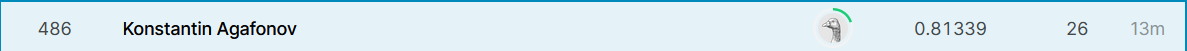

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [221]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [223]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [224]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [282]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [226]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [227]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [228]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

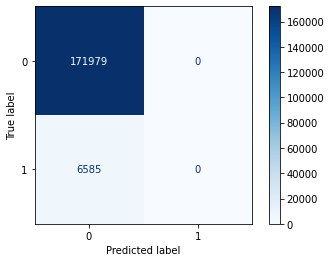

In [229]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [230]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

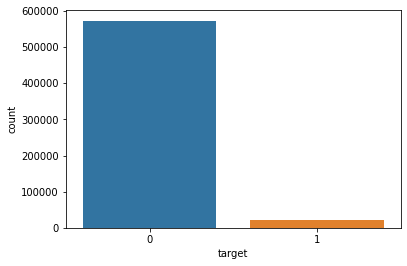

In [231]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [232]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

< your proof >

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

**Thoughts:** For imbalaced dataset F1-score, Precision and Recall metrics might be useful

Let's calculate the Normalized Gini Coefficient:

In [233]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [234]:
gini_normalized(y_valid, y_pred)

0.2558723581569817

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [239]:
insurance_data_y = insurance_data['target']

In [ ]:
# Code here